# Climate stripes demonstrated in a notebook

In [1]:
#!pip install -r requirements.txt

In [2]:
# Define the cache first
CACHE = {}

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import fsspec
from convertbng.util import convert_bng

RAL_LAT, RAL_LON = 51.570664384, -1.308832098

fpath = index_uri = "haduk-grid1.json"


def check_location_is_near(lat, lon, point_ds, ds, threshold=0.05):
    """
    Checks that selected eastings and northings (in BNG coordinates) are within the lat/lon threshold of
    the `lat` and `lon` requested by the user.

    Raises an exception if outside the acceptable threshold.

    Returns tuple of: (eastings, northings)
    """
    y = float(point_ds.projection_y_coordinate.values)
    x = float(point_ds.projection_x_coordinate.values)
    
    lat_diff = abs(float(ds.latitude.sel(projection_y_coordinate=y, projection_x_coordinate=x)) - lat)
    lon_diff = abs(float(ds.longitude.sel(projection_y_coordinate=y, projection_x_coordinate=x)) - lon)

    assert lat_diff < threshold, f"Lat diff is too big: {lat_diff}"
    assert lon_diff < threshold, f"Lon diff is too big: {lon_diff}"

    return (x, y)
    

def extract_time_series_at_location(lat=RAL_LAT, lon=RAL_LON, ref_period=(1901, 2000)):
        
    ref_period = tuple([str(dt) for dt in ref_period])
    compression = "zstd" if index_uri.split(".")[-1].startswith("zst") else None
    mapper = fsspec.get_mapper("reference://", fo=index_uri, target_options={"compression": compression})

    print("opening kerchunk...need bigger arrays and specify duplicate coords and lat lon from each")
    ds = xr.open_zarr(mapper, consolidated=False, use_cftime=True, decode_timedelta=False)

    print("convert to northings, eastings...")
    requested_eastings, requested_northings = [i[0] for i in convert_bng(lon, lat)] 
             #lat_lon_to_eastings_northings(lon, lat)
 
    print("extract nearest grid point...")
    temp_series = ds.tas.sel(projection_y_coordinate=requested_northings, projection_x_coordinate=requested_eastings, method="nearest")

    # Check the chosen location is near the requested location
    actual_eastings, actual_northings = check_location_is_near(lat, lon, temp_series, ds)

    # Get mean over reference period
    reference_mean = temp_series.sel(time=slice(*ref_period)).mean()

    # Construct content to return
    response = {
        "temp_series": temp_series.squeeze().compute(),
        "demeaned_temp_series": (temp_series - reference_mean).squeeze().compute(),
        "eastings": actual_eastings, "northings": actual_northings,
        "lat": float(ds.latitude.sel(projection_y_coordinate=actual_northings, projection_x_coordinate=actual_eastings)),
        "lon": float(ds.longitude.sel(projection_y_coordinate=actual_northings, projection_x_coordinate=actual_eastings))
    }
    print("Returning data objects...")
    return response

In [4]:
def get_colour_map(cmap_name="RdBu_r", n_colours=-1):
    args = [cmap_name]
    if n_colours > 1: 
        args.append(n_colours)

    cmap = plt.get_cmap(*args)
    cmap._init()
    return cmap

Loading from file...
opening kerchunk...need bigger arrays and specify duplicate coords and lat lon from each


/home/users/astephen/.local/lib/python3.10/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.28.0
  warnings.warn(


convert to northings, eastings...
extract nearest grid point...
Returning data objects...
Saving to cache...
Downloaded data...
Min and max: -1.2858517685740107 1.461810250355354
Starting plot


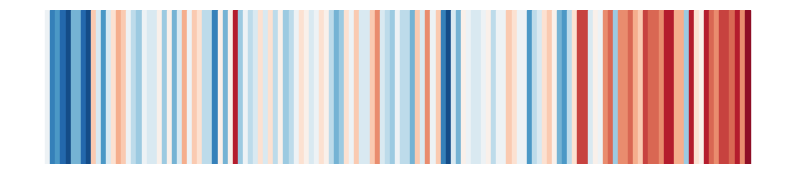

In [5]:
def rgba_to_hex(r, g, b, a=None):
    r, g, b = [int(i * 255) for i in (r, g, b)]
    return "#" + "".join([("0" + hex(i).split("x")[1])[-2:] for i in (r, g, b)])


def plot_climate_stripes_uk_location(lat, lon, n_colours=-1, cmap_name="RdBu_r", buffer=0.2):
    # # Round lat and lon to 6 significant values
    # n_sig = 6
    # lat, lon = [round(l, n_sig) for l in (lat, lon)]
    args = (lat, lon, n_colours, cmap_name)

    if args in CACHE.keys():
        print("Loading from cache...")
        data = CACHE[args]
    else:
        print("Loading from file...")
        resp = extract_time_series_at_location(lat, lon)
        years = resp["temp_series"].time.dt.year
    
        actual_values = resp["temp_series"].values
        stripes_data = resp["demeaned_temp_series"].values
        data = {"years": years, "actual_values": actual_values, "stripes_data": stripes_data}
        print("Saving to cache...")
        CACHE[args] = data
    
    print("Downloaded data...")
    # Unpack dictionary
    years, actual_values, stripes_data = data["years"], data["actual_values"], data["stripes_data"]

    print("Min and max:", stripes_data.min(), stripes_data.max())

    # Add a buffer around the lower and upper boundaries - to use only values within the colourmap
    normalised_data = plt.Normalize(stripes_data.min() - buffer, stripes_data.max() + buffer)
    cmap = get_colour_map(cmap_name, n_colours)
    
    fig, ax = plt.subplots(figsize=(10, 2))
    
    print("Starting plot")

    colours = []
    
    for i in range(stripes_data.shape[0]):
        actual_value = actual_values[i]
        year = years[i]
        normalised_value = normalised_data(stripes_data[i])
        rgba_colour = cmap(normalised_value)
        colours.append(rgba_colour)

        # collected.append([actual_value, normalised_value, colour])
        ax.axvspan(
            xmin=i - 0.5, xmax=i + 0.5, color=rgba_colour
        )
    
    ax.axis("off")

    df = pd.DataFrame({
        "years": years,
        "temp_value": actual_values,
        "temp_demeaned": stripes_data,
        "hex_colour": [rgba_to_hex(r, g, b) for (r, g, b, a) in colours],
        "red": [col[0] for col in colours],
        "green": [col[1] for col in colours],
        "blue": [col[2] for col in colours]
    })
        
    return df


df = plot_climate_stripes_uk_location(50.6200, -3.4137, n_colours=20)

In [6]:
df

,years,temp_value,temp_demeaned,hex_colour,red,green,blue
0,1884,10.744388,0.004872,#edf2f5,0.929412,0.950052,0.961404
1,1885,9.848488,-0.891029,#3480b9,0.206605,0.502167,0.726729
2,1886,9.984892,-0.754625,#4b98c5,0.295356,0.597110,0.775851
3,1887,9.646891,-1.092626,#2268ad,0.136429,0.409288,0.679257
4,1888,9.453665,-1.285852,#134c88,0.077399,0.299690,0.535191
...,...,...,...,...,...,...,...
134,2018,11.892818,1.153302,#c6413e,0.779773,0.257585,0.245820
135,2019,11.709645,0.970128,#d96752,0.851600,0.404954,0.323839
136,2020,11.950939,1.211423,#b31b2c,0.705470,0.108978,0.175645
137,2021,11.506322,0.766805,#e88b6e,0.913519,0.547368,0.433230


In [7]:
CMAP_NAME = "RdBu_r"
N = 20

def get_colours_lookup(cmap_name=CMAP_NAME, n=N):    
    cmap = get_colour_map(cmap_name, n)
    assert cmap.N == n
    
    cols = [((r, g, b), f"colour_{(i + 1):02d}") for i, (r, g, b, a) in enumerate(cmap._lut)]
    print(f"""
    There are {N} + 3 colours. 
    {[key for (col, key) in cols]}
    
    The last three rows are the colours for data low and high out-of-range values and for masked values.
    
    We have added a `buffer` when the data is normalised, to avoid the out-of-range colours being used.
    """)
    return dict(cols)


def get_extended_df(df):
    col_lookup = get_colours_lookup()
    df["colour_block"] = ""
    df.loc[:, "colour"] = df.apply(lambda row: col_lookup[(row["red"], row["green"], row["blue"])], axis=1)
    return df


def show_dataframe_with_colours(df, cmap_name=CMAP_NAME):
    gmap = np.array([df.temp_demeaned]).transpose()
    plt.rcParams["image.cmap"] = cmap_name
    return df.style.background_gradient(axis=None, gmap=gmap, cmap=None, subset=['colour_block'])


df = get_extended_df(df)

# Check that the colours 21, 22 and 23 are not used!
colours_used = set(df.colour.unique())
assert not colours_used.intersection("colour_21", "colour_22", "colour_23")
show_dataframe_with_colours(df)


    There are 20 + 3 colours. 
    ['colour_01', 'colour_02', 'colour_03', 'colour_04', 'colour_05', 'colour_06', 'colour_07', 'colour_08', 'colour_09', 'colour_10', 'colour_11', 'colour_12', 'colour_13', 'colour_14', 'colour_15', 'colour_16', 'colour_17', 'colour_18', 'colour_19', 'colour_20', 'colour_21', 'colour_22', 'colour_23']
    
    The last three rows are the colours for data low and high out-of-range values and for masked values.
    
    We have added a `buffer` when the data is normalised, to avoid the out-of-range colours being used.
    


,years,temp_value,temp_demeaned,hex_colour,red,green,blue,colour_block,colour
0,1884,10.744388,0.004872,#edf2f5,0.929412,0.950052,0.961404,,colour_10
1,1885,9.848488,-0.891029,#3480b9,0.206605,0.502167,0.726729,,colour_04
2,1886,9.984892,-0.754625,#4b98c5,0.295356,0.597110,0.775851,,colour_05
3,1887,9.646891,-1.092626,#2268ad,0.136429,0.409288,0.679257,,colour_03
4,1888,9.453665,-1.285852,#134c88,0.077399,0.299690,0.535191,,colour_02
5,1889,10.112778,-0.626739,#74b2d4,0.458411,0.700310,0.831579,,colour_06
6,1890,10.118856,-0.620661,#74b2d4,0.458411,0.700310,0.831579,,colour_06
7,1891,9.707666,-1.031851,#2268ad,0.136429,0.409288,0.679257,,colour_03
8,1892,9.548828,-1.190688,#134c88,0.077399,0.299690,0.535191,,colour_02
9,1893,11.152430,0.412914,#fac9b1,0.981011,0.791950,0.694943,,colour_13


This is what the above looks like when run interactively...

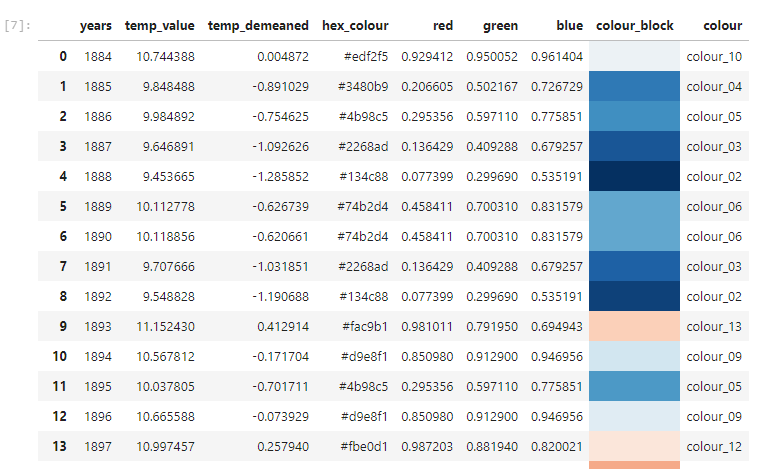

In [11]:
n_colours_used = len(df.colour.unique())
print(f"Number of colours used: {n_colours_used}")

Number of colours used: 18


## Appendices

### Appendix 1: Colour map definitions

You can define a colour map with unlimited (maybe 256 is the limit) colours, or specify your own limit, e.g.:

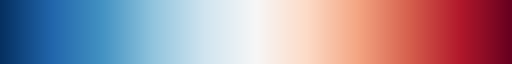

In [12]:
cmap = plt.get_cmap("RdBu_r")
cmap

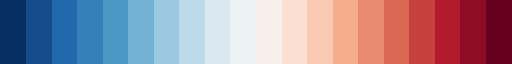

In [13]:
cmap = plt.get_cmap("RdBu_r", 20)
cmap